In [9]:
import numpy as np
import pandas as pd
from imblearn.combine import SMOTEENN
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [11]:
#Load and Preprocess Data
df = pd.read_csv('data_ecommerce_customer_churn.csv')
df.head(10)

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0
5,7.0,16.0,4,Mobile Phone,2,Divorced,2,0,11.0,152.81,0
6,1.0,15.0,6,Mobile Phone,5,Divorced,3,0,2.0,149.51,0
7,1.0,11.0,4,Mobile Phone,5,Single,3,0,1.0,154.73,1
8,11.0,12.0,4,Mobile Phone,3,Married,2,0,4.0,137.02,0
9,17.0,7.0,3,Laptop & Accessory,1,Married,5,1,2.0,157.43,0


In [12]:
#Show the total number of missing values in each column
print(df.isnull().sum())

Tenure                      194
WarehouseToHome             169
NumberOfDeviceRegistered      0
PreferedOrderCat              0
SatisfactionScore             0
MaritalStatus                 0
NumberOfAddress               0
Complain                      0
DaySinceLastOrder           213
CashbackAmount                0
Churn                         0
dtype: int64


In [16]:
# Handle missing values
df.fillna(df.select_dtypes(include=[np.number]).mean(), inplace=True)
df.head(10)

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.000000,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.000000,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.000000,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,4.531652,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.000000,322.17,0
5,7.0,16.0,4,Mobile Phone,2,Divorced,2,0,11.000000,152.81,0
6,1.0,15.0,6,Mobile Phone,5,Divorced,3,0,2.000000,149.51,0
7,1.0,11.0,4,Mobile Phone,5,Single,3,0,1.000000,154.73,1
8,11.0,12.0,4,Mobile Phone,3,Married,2,0,4.000000,137.02,0
9,17.0,7.0,3,Laptop & Accessory,1,Married,5,1,2.000000,157.43,0


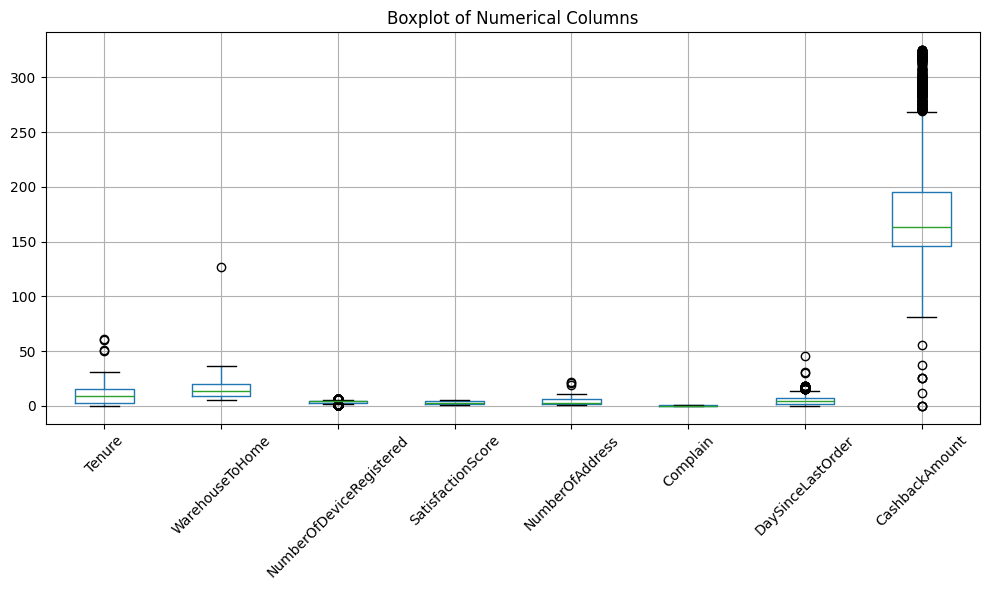

In [14]:
#Boxplot to visualize the distribution of numerical features
num_column = df.select_dtypes(include=['int64', 'float64']).columns
num_column = num_column.drop('Churn')
# Plot boxplot for all numerical columns
df[num_column].boxplot(figsize=(10, 6))
plt.title('Boxplot of Numerical Columns')
plt.xticks(rotation=45)  # Rotate labels if needed
plt.tight_layout()
plt.show()

In [18]:
# Encode categorical features
label_encoder = LabelEncoder()
df['PreferedOrderCat'] = label_encoder.fit_transform(df['PreferedOrderCat'])
df['MaritalStatus'] = label_encoder.fit_transform(df['MaritalStatus'])
df.head()

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,2,3,2,2,0,7.000000,143.32,0
1,7.0,25.0,4,3,1,1,2,0,7.000000,129.29,0
2,27.0,13.0,3,2,1,1,5,0,7.000000,168.54,0
3,20.0,25.0,4,0,3,0,7,0,4.531652,230.27,0
4,30.0,15.0,4,5,4,2,8,0,8.000000,322.17,0


In [19]:
# Feature scaling
scaler = StandardScaler()
features_to_scale = ['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered', 'SatisfactionScore',
                     'NumberOfAddress', 'DaySinceLastOrder', 'CashbackAmount']
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])
df.head()

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,0.593608,1.614590,0.316362,2,-0.063911,2,-0.852035,0,0.692058,-0.684370,0
1,-0.371883,1.130797,0.316362,3,-1.511448,1,-0.852035,0,0.692058,-0.971955,0
2,2.041846,-0.320584,-0.670017,2,-1.511448,1,0.290227,0,0.692058,-0.167415,0
3,1.197041,1.130797,0.316362,0,-0.063911,0,1.051736,0,0.000000,1.097918,0
4,2.403905,-0.078687,0.316362,5,0.659858,2,1.432490,0,0.972430,2.981671,0


In [21]:
# Feature Engineering
df['Tenure_Satisfaction'] = df['Tenure'] * df['SatisfactionScore']
df['RecencyAdjustedSatisfaction'] = df['SatisfactionScore'] / (df['DaySinceLastOrder'] + 1)
df['TenurePerDevice'] = df['Tenure'] / (df['NumberOfDeviceRegistered'] + 1)
df.head()

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn,Tenure_Satisfaction,RecencyAdjustedSatisfaction,TenurePerDevice
0,0.593608,1.614590,0.316362,2,-0.063911,2,-0.852035,0,0.692058,-0.684370,0,-0.037938,-0.037771,0.450946
1,-0.371883,1.130797,0.316362,3,-1.511448,1,-0.852035,0,0.692058,-0.971955,0,0.562082,-0.893261,-0.282508
2,2.041846,-0.320584,-0.670017,2,-1.511448,1,0.290227,0,0.692058,-0.167415,0,-3.086144,-0.893261,6.187725
3,1.197041,1.130797,0.316362,0,-0.063911,0,1.051736,0,0.000000,1.097918,0,-0.076504,-0.063911,0.909355
4,2.403905,-0.078687,0.316362,5,0.659858,2,1.432490,0,0.972430,2.981671,0,1.586237,0.334541,1.826173


In [22]:
# Features and target
X = df.drop(['Churn'], axis=1)
y = df['Churn']


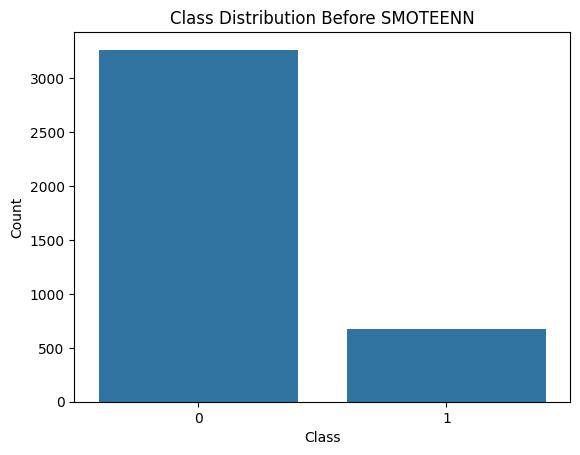

In [23]:
#Class distribution before SMOTEENN
def plot_class_distribution(y, title):
    sns.countplot(x=y)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()
plot_class_distribution(y, "Class Distribution Before SMOTEENN")

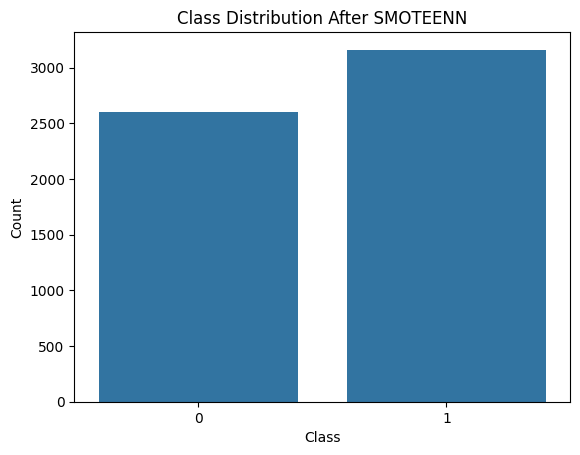

In [24]:
# Handle Class Imbalance and show visualization
smote_enn = SMOTEENN(random_state=42)
X_res, y_res = smote_enn.fit_resample(X, y)
plot_class_distribution(y_res, "Class Distribution After SMOTEENN")

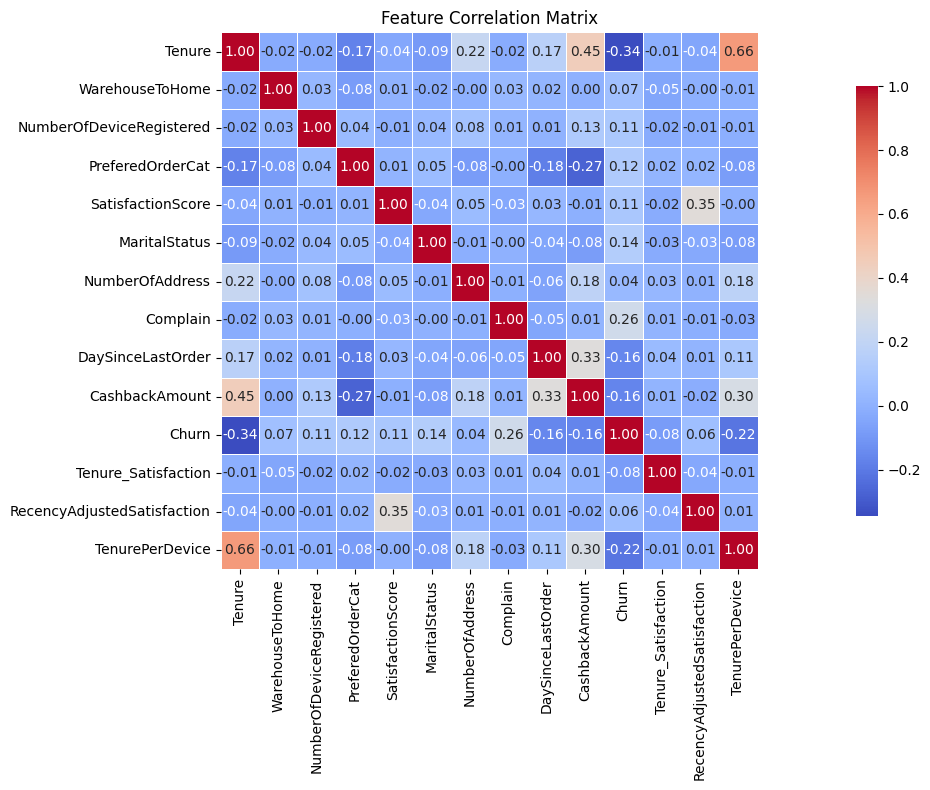

d:\ML Projects\Customer_Churn_Prediction_using_ML\correlation_matrix.png

In [31]:
#Correlation Matrix (Feature Relationships)
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix (only numeric columns)
corr_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True,
            cbar_kws={"shrink": .8}, linewidths=0.5)
plt.savefig("correlation_matrix.png", dpi=300, bbox_inches='tight')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()
from IPython.display import FileLink
FileLink('correlation_matrix.png')

In [25]:
#  Feature Selection
selector = SelectKBest(f_classif, k='all')
X_res_selected = selector.fit_transform(X_res, y_res)
X_selected_columns = X_res.columns[selector.get_support()]

In [26]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_res_selected, y_res, test_size=0.2, random_state=42)
np.random.seed(42)

In [27]:
#Initialize Models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': GradientBoostingClassifier(random_state=42)  # Replacing Decision Tree with GB for better meta-learner
}

In [28]:
#  Hyperparameter Tuning (optional)
def tune_model(model, param_grid, X_train, y_train):
    try:
        grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, verbose=0)
        grid_search.fit(X_train, y_train)
        return grid_search.best_estimator_, grid_search.best_params_
    except Exception as e:
        print(f"Tuning error: {e}")
        return model, None

In [29]:
# Evaluate Models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    try:
        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = time.time() - start_time

        y_pred = model.predict(X_test)
        train_accuracy = accuracy_score(y_train, model.predict(X_train)) * 100
        test_accuracy = accuracy_score(y_test, y_pred) * 100
        report = classification_report(y_test, y_pred)

        return train_accuracy, test_accuracy, report, training_time, y_pred
    except Exception as e:
        print(f"Evaluation error: {e}")
        return None, None, None, None, None

Evaluating Random Forest...
Random Forest Training Accuracy: 100.00%
Random Forest Test Accuracy: 98.01%
Time: 0.89s
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       530
           1       0.99      0.97      0.98       623

    accuracy                           0.98      1153
   macro avg       0.98      0.98      0.98      1153
weighted avg       0.98      0.98      0.98      1153



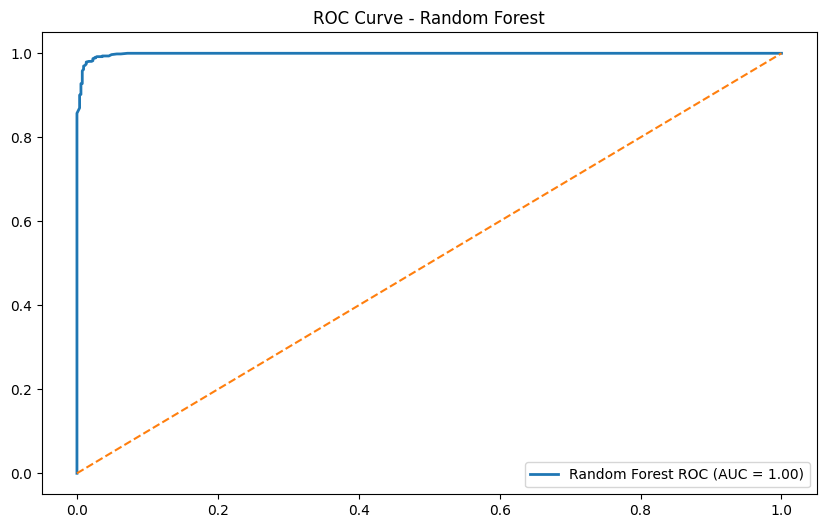

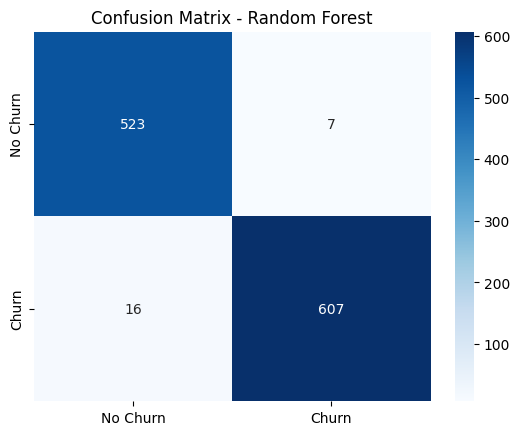

Evaluating XGBoost...
XGBoost Training Accuracy: 100.00%
XGBoost Test Accuracy: 97.83%
Time: 0.25s
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       530
           1       0.99      0.97      0.98       623

    accuracy                           0.98      1153
   macro avg       0.98      0.98      0.98      1153
weighted avg       0.98      0.98      0.98      1153



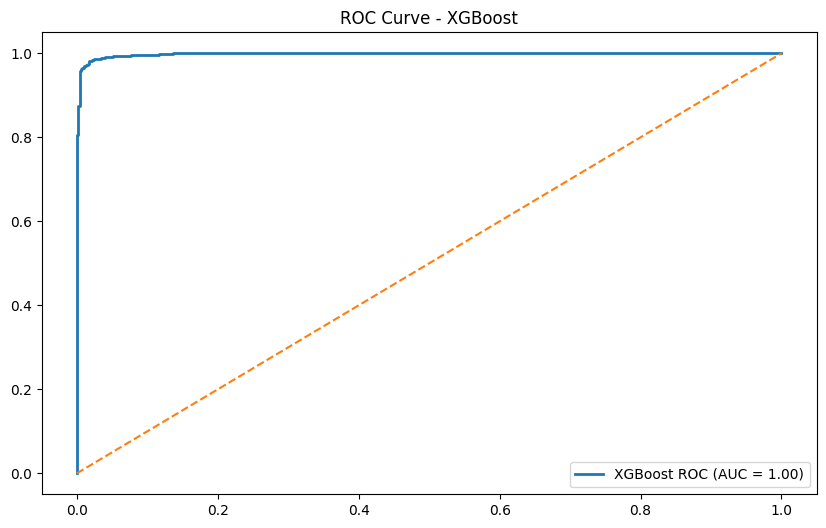

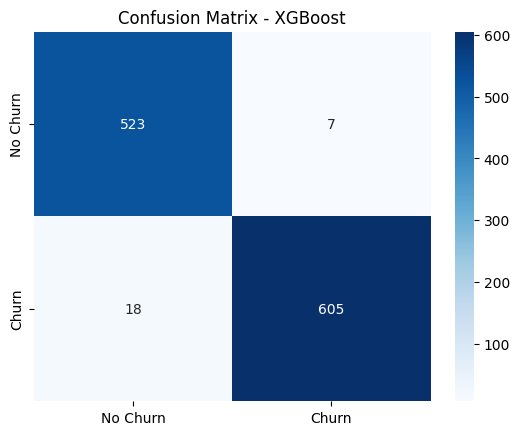

Evaluating Logistic Regression...
Logistic Regression Training Accuracy: 79.07%
Logistic Regression Test Accuracy: 79.18%
Time: 0.13s
              precision    recall  f1-score   support

           0       0.78      0.77      0.77       530
           1       0.80      0.81      0.81       623

    accuracy                           0.79      1153
   macro avg       0.79      0.79      0.79      1153
weighted avg       0.79      0.79      0.79      1153



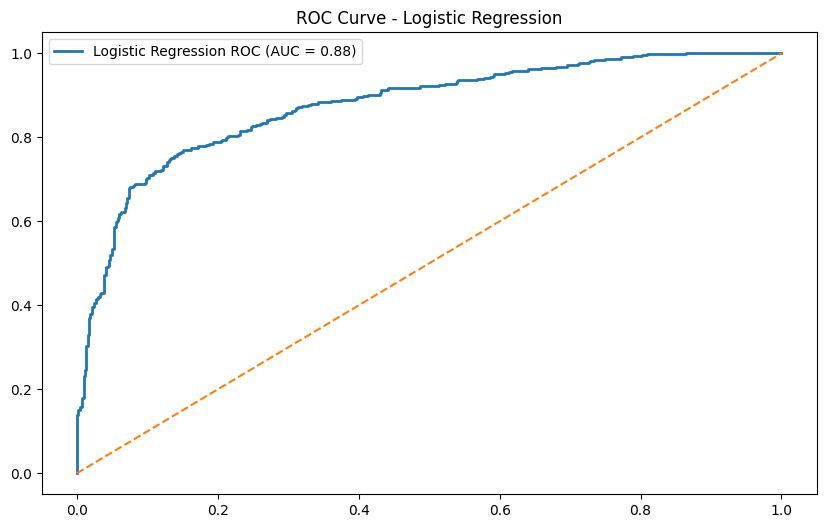

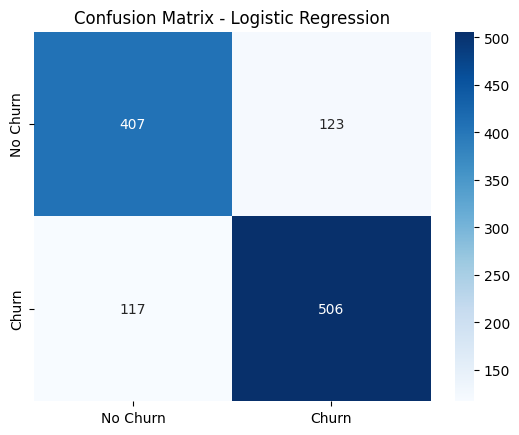

Evaluating Decision Tree...
Decision Tree Training Accuracy: 94.51%
Decision Tree Test Accuracy: 92.97%
Time: 1.38s
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       530
           1       0.95      0.92      0.93       623

    accuracy                           0.93      1153
   macro avg       0.93      0.93      0.93      1153
weighted avg       0.93      0.93      0.93      1153



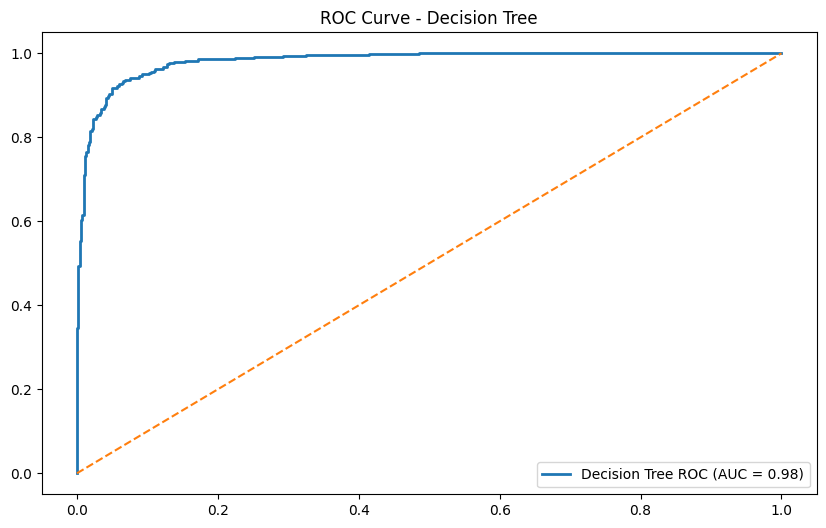

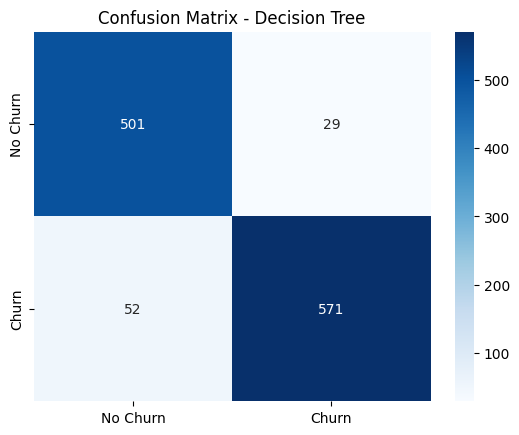

In [30]:
#Train and Evaluate Models
for name, model in models.items():
    print(f"Evaluating {name}...")
    train_accuracy, test_accuracy, report, training_time, y_pred = evaluate_model(model, X_train, X_test, y_train, y_test)

    if train_accuracy is not None:
        print(f"{name} Training Accuracy: {train_accuracy:.2f}%")
        print(f"{name} Test Accuracy: {test_accuracy:.2f}%")
        print(f"Time: {training_time:.2f}s")
        print(report)

        fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(10, 6))
        plt.plot(fpr, tpr, lw=2, label=f'{name} ROC (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.title(f'ROC Curve - {name}')
        plt.legend()
        plt.show()

        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
        plt.title(f'Confusion Matrix - {name}')
        plt.show()